#Understanding the Yolo Algorithm and Fine-Tuning It
____


# Overview of Yolo Algorithm

The YOLO algorithm is designed to preform object detection and image classification. Usually, detection and classification are often two separate models which take two passes, however, yolo combines the two in one pass which is why it's named you only look one. This allows for quick detection and the ability to be used in real time applications.  The following output looks like this:

<img src="cover.png" width="400" height="300">

Yolo does object detection and classification in one pass by dividing the image into an SXS Matrix like the image below:

<img src="SXS.png" width="300" height="300">

Then for each cell two categories of features is created, the first, is on the object detection boxes and the second is classification of each SXS square. The Object Detction is done in the following way. For each rectangle in SXS we take a finite amount of bounding boxes. For example if we take two boxes per rectange we would have to vectors with the following data:

                                    [x, y, sqrt(W), sqrt(H), C]

X, Y are the center coordinates of the bounding box, W and H are the width and height, and C which is a confidence score representing the models confidence that an object actually exists in the bounding box.
Additionally, we have a tensor with the following data 

                                    [P(c1), P(c2), ... P(cn)]

This represents what is the probability that what is in the SXS cell is a given classification. So for each grid, we eventually build a (Bx5+n) matrix where B is the number of bounding boxes and n is the number of classifications in the model. We repeat this process for each cell in the SXS grid until we have a final feature matrix. 

We then use a loss function, which will be explained later in this markdown to compute both how well the bounding boxes are predicting object, how well the model is classified, and how well the combination is doing. 

Because we gather all the data in one pass, yolo can run quite fast. The newest versions run at 45 frames per second while optimized versions can process at 150 frames per second with 25 milliseconds of latency. The best alternative RCNN's most opitmized version runs at about max 17 frames per second. 

In this tutorial, we will teach you how to implement YoloV1, we will then shop how to pull the YoloV8 pre trained off the web and opotimize it for your preferred use.

# Data Engineering

Gage

In [ ]:
import torch
import torch.nn as nn
import pandas as pd
import os
import PIL
import skimage
from skimage import io
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import torchvision.transforms as transforms
import torch.optim as optim
import torchvision.transforms.functional as FT
from torch.utils.data import DataLoader
from tqdm import tqdm
seed = 123
import xml.etree.ElementTree as ET
torch.manual_seed(seed)
from collections import Counter


files_dir = './archive/train'
test_dir = './archive/test'

images = [image for image in sorted(os.listdir(files_dir))
                        if image[-4:]=='.jpg']
annots = []
for image in images:
    annot = image[:-4] + '.xml'
    annots.append(annot)
    
images = pd.Series(images, name='images')
annots = pd.Series(annots, name='annots')
df = pd.concat([images, annots], axis=1)
df = pd.DataFrame(df)

test_images = [image for image in sorted(os.listdir(test_dir))
                        if image[-4:]=='.jpg']

test_annots = []
for image in test_images:
    annot = image[:-4] + '.xml'
    test_annots.append(annot)

test_images = pd.Series(test_images, name='test_images')
test_annots = pd.Series(test_annots, name='test_annots')
test_df = pd.concat([test_images, test_annots], axis=1)
test_df = pd.DataFrame(test_df)

In [5]:
class FruitImagesDataset(torch.utils.data.Dataset):
    def __init__(self, df=df, files_dir=files_dir, S=7, B=2, C=3, transform=None):
        self.annotations = df
        self.files_dir = files_dir
        self.transform = transform
        self.S = S
        self.B = B
        self.C = C

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, index):
        label_path = os.path.join(self.files_dir, self.annotations.iloc[index, 1])
        boxes = []
        tree = ET.parse(label_path)
        root = tree.getroot()
        
        class_dictionary = {'apple':0, 'banana':1, 'orange':2}
    
        if(int(root.find('size').find('height').text) == 0):
            filename = root.find('filename').text
            img = Image.open(self.files_dir + '/' + filename)
            img_width, img_height = img.size
            
            for member in root.findall('object'):
            
                klass = member.find('name').text
                klass = class_dictionary[klass]
            
                # bounding box
                xmin = int(member.find('bndbox').find('xmin').text)
                xmax = int(member.find('bndbox').find('xmax').text)
            
                ymin = int(member.find('bndbox').find('ymin').text)
                ymax = int(member.find('bndbox').find('ymax').text)
                
                centerx = ((xmax + xmin) / 2) / img_width
                centery = ((ymax + ymin) / 2) / img_height
                boxwidth = (xmax - xmin) / img_width
                boxheight = (ymax - ymin) / img_height
            
            
                boxes.append([klass, centerx, centery, boxwidth, boxheight])
            
        elif(int(root.find('size').find('height').text) != 0):
            
            for member in root.findall('object'):
            
                klass = member.find('name').text
                klass = class_dictionary[klass]
            
                                # bounding box
                xmin = int(member.find('bndbox').find('xmin').text)
                xmax = int(member.find('bndbox').find('xmax').text)
                img_width = int(root.find('size').find('width').text)
            
                ymin = int(member.find('bndbox').find('ymin').text)
                ymax = int(member.find('bndbox').find('ymax').text)
                img_height = int(root.find('size').find('height').text)
                
                centerx = ((xmax + xmin) / 2) / img_width
                centery = ((ymax + ymin) / 2) / img_height
                boxwidth = (xmax - xmin) / img_width
                boxheight = (ymax - ymin) / img_height
            
            
                boxes.append([klass, centerx, centery, boxwidth, boxheight])

                
        boxes = torch.tensor(boxes)
        img_path = os.path.join(self.files_dir, self.annotations.iloc[index, 0])
        image = Image.open(img_path)
        image = image.convert("RGB")

        if self.transform:
            # image = self.transform(image)
            image, boxes = self.transform(image, boxes)

        # Convert To Cells
        label_matrix = torch.zeros((self.S, self.S, self.C + 5 * self.B))
        for box in boxes:
            class_label, x, y, width, height = box.tolist()
            class_label = int(class_label)

            # i,j represents the cell row and cell column
            i, j = int(self.S * y), int(self.S * x)
            x_cell, y_cell = self.S * x - j, self.S * y - i

            """
            Calculating the width and height of cell of bounding box,
            relative to the cell is done by the following, with
            width as the example:
            
            width_pixels = (width*self.image_width)
            cell_pixels = (self.image_width)
            
            Then to find the width relative to the cell is simply:
            width_pixels/cell_pixels, simplification leads to the
            formulas below.
            """
            width_cell, height_cell = (
                width * self.S,
                height * self.S,
            )

            # If no object already found for specific cell i,j
            # Note: This means we restrict to ONE object
            # per cell!
#             print(i, j)
            if label_matrix[i, j, self.C] == 0:
                # Set that there exists an object
                label_matrix[i, j, self.C] = 1

                # Box coordinates
                box_coordinates = torch.tensor(
                    [x_cell, y_cell, width_cell, height_cell]
                )

                label_matrix[i, j, 4:8] = box_coordinates

                # Set one hot encoding for class_label
                label_matrix[i, j, class_label] = 1

        return image, label_matrix

# Model Overview / Example Usage

In [1]:
from PIL import Image, ImageDraw

## Get Image ##

## Get Prediction ##
model = YOLO()
model.eval()
predictions = model(image)
boxes, scores, classes = post_process(predictions)


## Draw predictions on original image ##
draw = ImageDraw.Draw(image)
for box in boxes:
    draw.rectangle([(box[0], box[1]), (box[2], box[3])], outline="red")

image.show()

NameError: name 'YOLO' is not defined

Ben

# Loss Function

### Parameters

grid_size: the original image is divided into a grid with length grid_size  
num_boxes: number of bounding boxes to be predicted in each grid cell  
num_classes: number of classes an object can be identified as  

### Intersection over Union Utility Function

The intersection over Union metric is used to determine how well the predicted box matches the annotated box label. The function is essentially a ratio where the numerator is the overlap between the predictions and the denominator is the total area of the predictions. As a result, a perfect match would have an IoU score of 1, and worse predictions would have a score less than 1.

In [6]:
def intersection_over_union(boxes_preds, boxes_labels):
    """
    Parameters:
        boxes_preds (tensor): Predictions of Bounding Boxes (num_boxes, 4)
        boxes_labels (tensor): Correct labels of Bounding Boxes (num_boxes, 4)
    """

    ## Determine the boundary corners of the box given a box is defined in the params by (x,y,w,h) ##
    box1_x1 = boxes_preds[..., 0:1] - boxes_preds[..., 2:3] / 2
    box1_y1 = boxes_preds[..., 1:2] - boxes_preds[..., 3:4] / 2
    box1_x2 = boxes_preds[..., 0:1] + boxes_preds[..., 2:3] / 2
    box1_y2 = boxes_preds[..., 1:2] + boxes_preds[..., 3:4] / 2
    box2_x1 = boxes_labels[..., 0:1] - boxes_labels[..., 2:3] / 2
    box2_y1 = boxes_labels[..., 1:2] - boxes_labels[..., 3:4] / 2
    box2_x2 = boxes_labels[..., 0:1] + boxes_labels[..., 2:3] / 2
    box2_y2 = boxes_labels[..., 1:2] + boxes_labels[..., 3:4] / 2

    combined_x1 = torch.max(box1_x1, box2_x1)
    combined_y1 = torch.max(box1_y1, box2_y1)
    combined_x2 = torch.min(box1_x2, box2_x2)
    combined_y2 = torch.min(box1_y2, box2_y2)

    intersection = (combined_x2 - combined_x1).clamp(0) * (combined_y2 - combined_y1).clamp(0) # Clamp where there is no intersection
    
    box1_area = abs((box1_x2 - box1_x1) * (box1_y2 - box1_y1))
    box2_area = abs((box2_x2 - box2_x1) * (box2_y2 - box2_y1))

    return intersection / (box1_area + box2_area - intersection + 1e-6) # include 1e-6 for no division by 0 error


### Loss Function for Box Coordinates

In [ ]:
def loss_fn_box_coordinates(predictions, target, grid_size=7, num_boxes=2, num_classes=3):
    
    ## First calculate IoUs for the two bounding box predictions
    iou_b1 = intersection_over_union(predictions[..., num_classes + 1:num_classes + 5], target[..., num_classes + 1:num_classes + 5])
    iou_b2 = intersection_over_union(predictions[..., num_classes + 6:num_classes + 10], target[..., num_classes + 1:num_classes + 5])
    ious = torch.cat([iou_b1.unsqueeze(0), iou_b2.unsqueeze(0)], dim=0)

    iou_maxes, bestbox = torch.max(ious, dim=0)
    exists_box = target[..., num_classes].unsqueeze(3)

# CNN Implementation

Each CNN layer is very standard to what we've learned in class.  
1) There is first have a 2d Convolutional layer.  
2) That output gets fed through a 2d normalizer to prevent overfitting  
3) That output is passed through a leaky ReLU activation function

In [8]:
class CNNBlock(nn.Module):
    def __init__(self, in_channels, out_channels, **kwargs):
        super(CNNBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, bias=False, **kwargs)
        self.batchnorm = nn.BatchNorm2d(out_channels)
        self.leakyrelu = nn.LeakyReLU(0.1)
        
    def forward(self, x):
        return self.leakyrelu(self.batchnorm(self.conv(x)))

### The Architecture Comes Directly From the Paper

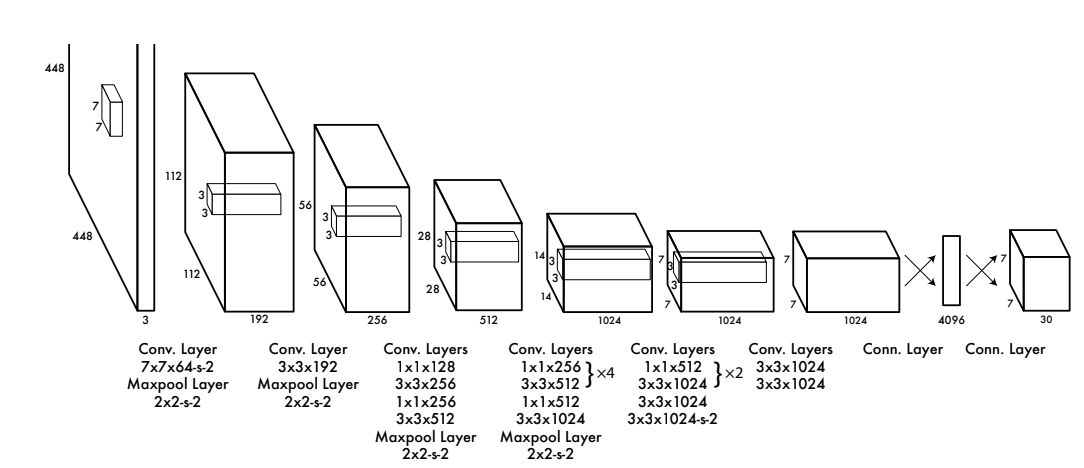

In [10]:
from IPython.display import Image
Image(filename="./architecture.png")

As can be seen from the image pulled from the paper, the architecture defined below comes directly from the paper. The only difference is the last two layers (labeled as 4096 and 7x7x30) are defined later as they are not part of the convolutional architecture but are the "decoder" for the network defined in the fully connected layers network.

In [14]:
def create_conv_layers(in_channels):
        layers = [CNNBlock(in_channels, 64, kernel_size=7, stride=2, padding=3),
                  nn.MaxPool2d(kernel_size=2, stride=2),
                  CNNBlock(64, 192, kernel_size=3, stride=1, padding=1),
                  nn.MaxPool2d(kernel_size=2, stride=2),
                  CNNBlock(192, 128, kernel_size=1, stride=1, padding=0),
                  CNNBlock(128, 256, kernel_size=3, stride=1, padding=1),
                  CNNBlock(256, 256, kernel_size=1, stride=1, padding=0),
                  CNNBlock(256, 512, kernel_size=3, stride=1, padding=1),
                  nn.MaxPool2d(kernel_size=2, stride=2),
                  CNNBlock(512, 256, kernel_size=1, stride=1, padding=0),
                  CNNBlock(256, 512, kernel_size=3, stride=1, padding=1),
                  CNNBlock(512, 256, kernel_size=1, stride=1, padding=0),
                  CNNBlock(256, 512, kernel_size=3, stride=1, padding=1),
                  CNNBlock(512, 256, kernel_size=1, stride=1, padding=0),
                  CNNBlock(256, 512, kernel_size=3, stride=1, padding=1),
                  CNNBlock(512, 256, kernel_size=1, stride=1, padding=0),
                  CNNBlock(256, 512, kernel_size=3, stride=1, padding=1),
                  CNNBlock(512, 512, kernel_size=1, stride=1, padding=0),
                  CNNBlock(512, 1024, kernel_size=3, stride=1, padding=1),
                  nn.MaxPool2d(kernel_size=2, stride=2),
                  CNNBlock(1024, 512, kernel_size=1, stride=1, padding=0),
                  CNNBlock(512, 1024, kernel_size=3, stride=1, padding=1),
                  CNNBlock(1024, 512, kernel_size=1, stride=1, padding=0),
                  CNNBlock(512, 1024, kernel_size=3, stride=1, padding=1),
                  CNNBlock(1024, 1024, kernel_size=3, stride=1, padding=1),
                  CNNBlock(1024, 1024, kernel_size=3, stride=2, padding=1),
                  CNNBlock(1024, 1024, kernel_size=3, stride=1, padding=1),
                  CNNBlock(1024, 1024, kernel_size=3, stride=1, padding=1),
                  ]
                    
        return nn.Sequential(*layers)

The decoder is a feed forward network that inputs a vector of features and returns a flattened output vector. As described in the paper, the fully connected layer network consists of a linear layer, dropout layer, leaky ReLU activation function, and finally another linear layer.

In [15]:
def create_fcs(split_size, num_boxes, num_classes):
    S, B, C = split_size, num_boxes, num_classes
    return nn.Sequential(nn.Flatten(), nn.Linear(1024 * S * S, 496), nn.Dropout(0.0), nn.LeakyReLU(0.1), nn.Linear(496, S * S * (C + B * 5)))
    #Original paper uses nn.Linear(1024 * S * S, 4096) not 496. Also the last layer will be reshaped to (S, S, 13) where C+B*5 = 13

### YoloV1 Module

In [17]:
class YoloV1(nn.Module):
    def __init__(self, in_channels=3, **kwargs):
        super(YoloV1, self).__init__()
        self.in_channels = in_channels
        self.darknet = create_conv_layers(self.architecture)
        self.fcs = create_fcs(**kwargs)

        
    def forward(self, x):
        x = self.darknet(x)
        return self.fcs(torch.flatten(x, start_dim=1))

Ben

# Training


Gage

In [ ]:
LEARNING_RATE = 2e-5
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 16 # 64 in original paper but resource exhausted error otherwise.
WEIGHT_DECAY = 0
EPOCHS = 20
NUM_WORKERS = 2
PIN_MEMORY = True
LOAD_MODEL = False
LOAD_MODEL_FILE = "model.pth"

In [ ]:
def train_fn(train_loader, model, optimizer, loss_fn):
    loop = tqdm(train_loader, leave=True)
    mean_loss = []
    
    for batch_idx, (x, y) in enumerate(loop):
        x, y = x.to(DEVICE), y.to(DEVICE)
        out = model(x)
        loss = loss_fn(out, y)
        mean_loss.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        loop.set_postfix(loss = loss.item())
        
    print(f"Mean loss was {sum(mean_loss) / len(mean_loss)}")

In [ ]:
class Compose(object):
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, img, bboxes):
        for t in self.transforms:
            img, bboxes = t(img), bboxes

        return img, bboxes


transform = Compose([transforms.Resize((448, 448)), transforms.ToTensor()])

In [ ]:
def main():
    model = YoloV1(split_size=7, num_boxes=2, num_classes=3).to(DEVICE)
    optimizer = optim.Adam(
        model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY
    )
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer, factor=0.1, patience=3, mode='max', verbose=True)
    loss_fn = YoloLoss()

    if LOAD_MODEL:
        load_checkpoint(torch.load(LOAD_MODEL_FILE), model, optimizer)

    train_dataset = FruitImagesDataset(
        transform=transform,
        files_dir=files_dir
    )

    test_dataset = FruitImagesDataset(
        transform=transform, 
        files_dir=test_dir
    )

    train_loader = DataLoader(
        dataset=train_dataset,
        batch_size=BATCH_SIZE,
        shuffle=True,
        drop_last=False,
    )

    test_loader = DataLoader(
        dataset=test_dataset,
        batch_size=BATCH_SIZE,
        shuffle=True,
        drop_last=False,
    )

    for epoch in range(EPOCHS):
        train_fn(train_loader, model, optimizer, loss_fn)
        
        pred_boxes, target_boxes = get_bboxes(
            train_loader, model, iou_threshold=0.5, threshold=0.4
        )

        mean_avg_prec = mean_average_precision(
            pred_boxes, target_boxes, iou_threshold=0.5, box_format="midpoint"
        )
        print(f"Train mAP: {mean_avg_prec}")
        
        scheduler.step(mean_avg_prec)
    
    checkpoint = {
            "state_dict": model.state_dict(),
            "optimizer": optimizer.state_dict(),
    }
    save_checkpoint(checkpoint, filename=LOAD_MODEL_FILE)
    



if __name__ == "__main__":
    main()

# Implementing Yolov8 for custom implementation

The Yolo model is pretrained on the COCO Data Set:
https://cocodataset.org/#home

In [2]:
from ultralytics import YOLO
from IPython.display import display, Image

model = YOLO("yolov8m.pt")

There are multiple models you can select, just remeber the bigger models will be more acurate in predictions but it will cause the model to be slower, so take into account what may be best for your specific application:

| Classification  | Detection | Segmentation   | Kind |
|-------|-----|------------| ----- |
| yolov8n-cls.pt | yolov8n.pt |	yolov8n-seg.pt |	Nano |
| yolov8s-cls.pt |	yolov8s.pt| yolov8s-seg.pt	| Small |
| yolov8m-cls.pt | yolov8m.pt | yolov8m-seg.pt	| Medium | 
| yolov8l-cls.pt | yolov8l.pt |	yolov8l-seg.pt	| Large |
| yolov8x-cls.pt | yolov8x.pt |	yolov8x-seg.pt	| Huge |



Here is how you use the model on a basic image, like a stop sign:  
<img src="Stop.jpg" width="400" height="400"> . 
But when we pass a yield sign, it can't detect any object: 
<img src="Yield.jpg" width="400" height="400"> . 



image 1/1 /Users/aidanhousenbold/GHW_DeepLearningProject/Stop.jpg: 448x640 1 car, 2 trucks, 1 stop sign, 229.3ms
Speed: 4.8ms preprocess, 229.3ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)
Results saved to runs/detect/predict

image 1/1 /Users/aidanhousenbold/GHW_DeepLearningProject/Yield.jpg: 448x640 (no detections), 141.9ms
Speed: 1.2ms preprocess, 141.9ms inference, 0.7ms postprocess per image at shape (1, 3, 448, 640)
Results saved to runs/detect/predict


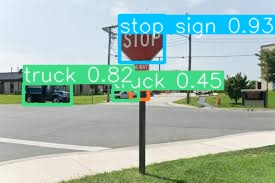

In [7]:
from IPython.display import Image

results1 = model.predict("Stop.jpg", save=True, save_crop = True)
results2 = model.predict("Yield.jpg")
Image(filename='runs/detect/predict/Stop.jpg')

As you can see, a yield sign is not detected. You can see what items are in the COCO set here:

In [4]:
result = results1[0]
print("stop sign")
if result.boxes != None:
    for box in result.boxes:
        class_id = result.names[box.cls[0].item()]
        cords = box.xyxy[0].tolist()
        cords = [round(x) for x in cords]
        conf = round(box.conf[0].item(), 2)
        print("Object type:", class_id)
        print("Coordinates:", cords)
        print("Probability:", conf)
        print("---")
else:
   print("no objects detected")

print("yield sign image")
result = results2[0]
for box in result.boxes:
        class_id = result.names[box.cls[0].item()]
        cords = box.xyxy[0].tolist()
        cords = [round(x) for x in cords]
        conf = round(box.conf[0].item(), 2)
        print("Object type:", class_id)
        print("Coordinates:", cords)
        print("Probability:", conf)
        print("---")

stop sign
Object type: stop sign
Coordinates: [120, 16, 165, 63]
Probability: 0.93
---
Object type: truck
Coordinates: [23, 83, 72, 104]
Probability: 0.82
---
Object type: truck
Coordinates: [112, 89, 139, 100]
Probability: 0.45
---
Object type: car
Coordinates: [131, 89, 149, 100]
Probability: 0.45
---
yield sign image


So we can use a specialized data set to train our model onto be good at traffic sign image detection for applications like self driving cars:
https://www.kaggle.com/datasets/pkdarabi/cardetection  The following code will let us train our model on the signs dataset


In [5]:
import os
model.train(data="data.yaml", epochs=30)

New https://pypi.org/project/ultralytics/8.2.6 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.2.2 🚀 Python-3.11.8 torch-2.2.0 CPU (Apple M1 Max)
engine/trainer: task=detect, mode=train, model=yolov8m.pt, data=data.yaml, epochs=30, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train14, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_

train: Scanning /Users/aidanhousenbold/GHW_DeepLearningProject/self/train/labels.cache... 3530 images, 3 backgrounds, 0 corrupt: 100%|██████████| 3530/3530 [00:00<?, ?it/s]
val: Scanning /Users/aidanhousenbold/GHW_DeepLearningProject/self/valid/labels.cache... 801 images, 0 backgrounds, 0 corrupt: 100%|██████████| 801/801 [00:00<?, ?it/s]


Plotting labels to runs/detect/train14/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000526, momentum=0.9) with parameter groups 77 weight(decay=0.0), 84 weight(decay=0.0005), 83 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs/detect/train14
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30         0G      2.786      5.255      2.749         44        640:   4%|▍         | 9/221 [03:58<1:33:45, 26.54s/it]


KeyboardInterrupt: 